In [1]:
import os, pickle, h5py, re
import pandas as pd
import numpy as np
from sklearn.mixture import BayesianGaussianMixture
from collections import defaultdict

In [2]:
os.environ['PATH'] = '/opt/anaconda3/bin:/opt/anaconda3/condabin:/usr/local/bin:/usr/bin:/bin:/usr/sbin:/sbin'

In [9]:
def get_top_genes_and_barcodes_list(file_name, n_genes=100):
    ''' Takes a 10x .h5 file and a number of genes (n) and returns a list of the top n expressed genes by counts'''
    dset = h5py.File(file_name, 'r')
    dset = dset['matrix']
    indices = dset['indices']
    data = dset['data']
    features = dset['features']
    ids = features['id']
    names = features['name']
    barcodes = pd.Series(dset['barcodes'][()]).astype('str').str.replace('b','').str.replace("'",'')
    
    counts = pd.DataFrame({'count':data,'gene':indices})
    counts = counts.groupby('gene').sum().reset_index()
    
    ensembl = pd.DataFrame({'ids':ids,'names':names})
    ensembl = ensembl.apply(lambda x: x.astype('str').str.replace('b','')).reset_index()
    
    temp = pd.merge(left=counts,right=ensembl,how="left",left_on='gene',right_on='index')
    top_genes = temp.sort_values('count',ascending=False).reset_index()[['count','ids','names']].head(n_genes)
    
    return top_genes, barcodes

In [98]:
def gtf_top_genes(top_genes, gtf_file):
    ''' Takes a list of genes and ensembl gtf file and makes a data frame that has a 
    column for chromosome, strand and a column that contains a set of all the genomic positions inside exons
    This is slow
    '''
    exon_list=[]
    chrom_list=[]
    strand_list=[]
    for i in top_genes['ids']:
        print(i)
        ensembl = !grep $i $gtf_file | cut -f1,3,4,5,7
        try:
            exons = list(map(lambda x: ('\texon') in x, ensembl))
            ensembl = np.array(ensembl)
            ensembl = ensembl[exons]
            chrom = re.findall('(chr[^\t]*)',ensembl[0])[0]
            temp = list(map(lambda x: set(x), map(lambda x: range(int(re.findall('\t([0-9]*)',x)[1]),\
                                                      int(re.findall('\t([0-9]*)',x)[2])), ensembl)))
            exons = list(set([i for i in temp for i in i]))
            exon_list.append(exons)
            chrom_list.append(chrom)
            strand = ensembl[0][-1]
            strand_list.append(strand)
        except: #in case id is not in gtf for some reason
            exon_list.append(0)
            chrom_list.append(0)
            strand_list.append(0)
            
    df  = pd.DataFrame({'gene_id':top_genes['ids'], 'name':top_genes['names'], 'chrom':chrom_list, 'exons':exon_list, 'strand':strand_list})
    df = df[df['chrom'] != 0] 
    return df

In [73]:
def samtools_view(df, filtered_barcodes, bam_file): 
    ''' Takes a df from gtf_top_genes and finds all reads that start between the first exon position and the last. 
    Makes a column for all of the cell barcodes and a column for all the read end positions relative to the first exon position.
    '''
    df = df.reset_index()
    read_stops_list_of_list=[]
    barcodes_list_of_list = []
    for i in range(len(df)):
        if df.loc[i,'strand'] == "+":
            print(i)
            chrom = df.loc[i,'chrom']
            start = min(df.loc[i, 'exons'])
            stop = max(df.loc[i, 'exons'])
            view = !samtools view $bam_file $chrom:$start-$stop

            print('parsing view')
            umi = list(map(lambda x: re.findall('UB:Z:([A-Z]+)', x),view))
            barcodes = list(map(lambda x: re.findall('CB:Z:([A-Z]+-[0-9]+)', x),view))
            read_strand = list(map(lambda x: x.split('\t')[1],view))
            read_starts = list(map(lambda x: x.split('\t')[3],view))
            cigars = list(map(lambda x: x.split('\t')[5],view))
            cigars = list(map(lambda x: re.findall('[0-9]+', x), cigars))
            cigars = list(map(lambda x: sum([int(s) for s in x]), cigars))
            read_stops = np.array(list(map(int,read_starts))) + np.array(cigars)
            print('making test')

            test = pd.DataFrame({'umi':umi,'read_starts':read_starts,'read_strand':read_strand,'barcodes':barcodes,'read_stops':read_stops})
            test = test[test['read_strand']=='0']
            test = test[list(map(lambda x: len(x) != 0, test['umi']))]
            test = test[list(map(lambda x: len(x) != 0, test['barcodes']))]
            test['umi'] = list(map(lambda x: x[0], test['umi']))
            test['barcodes'] = list(map(lambda x: x[0], test['barcodes']))
            test = test[test['barcodes'].isin(filtered_barcodes)]
            test = test.sort_values(by=['umi','read_starts'])
            test = test.drop_duplicates('umi', keep='first')
            print('appending_list')

            read_stops_list_of_list.append(list(test['read_stops']))
            barcodes_list_of_list.append(list(test['barcodes']))
            
        if df.loc[i,'strand'] == "-":
            print(i)
            chrom = df.loc[i,'chrom']
            actual_start = min(df.loc[i, 'exons']) 
            start = min(df.loc[i, 'exons']) - 300000
            stop = max(df.loc[i, 'exons'])
            view = !samtools view $bam_file $chrom:$start-$stop

            print('parsing view')
            umi = list(map(lambda x: re.findall('UB:Z:([A-Z]+)', x),view))
            barcodes = list(map(lambda x: re.findall('CB:Z:([A-Z]+-[0-9]+)', x),view))
            read_strand = list(map(lambda x: x.split('\t')[1],view))
            read_starts = list(map(lambda x: x.split('\t')[3],view))
            cigars = list(map(lambda x: x.split('\t')[5],view))
            cigars = list(map(lambda x: re.findall('[0-9]+', x), cigars))
            cigars = list(map(lambda x: sum([int(s) for s in x]), cigars))
            read_stops = np.array(list(map(int,read_starts))) + np.array(cigars)

            print('making test')
            test = pd.DataFrame({'umi':umi,'read_starts':read_starts,'read_strand':read_strand,'barcodes':barcodes,'read_stops':read_stops})
            test = test[test['read_strand']=='16']
            test = test[(test['read_stops'] > actual_start) & (test['read_stops'] < stop)]
            test = test[list(map(lambda x: len(x) != 0, test['umi']))]
            test = test[list(map(lambda x: len(x) != 0, test['barcodes']))]
            test['umi'] = list(map(lambda x: x[0], test['umi']))
            test['barcodes'] = list(map(lambda x: x[0], test['barcodes']))
            test = test[test['barcodes'].isin(filtered_barcodes)]
            test = test.sort_values(by=['umi','read_starts'], ascending=[True,False])
            test = test.drop_duplicates('umi', keep='first')
            print('appending_list')

            read_stops_list_of_list.append(list(test['read_starts']))
            barcodes_list_of_list.append(list(test['barcodes']))
        
    df['barcodes'] = barcodes_list_of_list
    df['read_stops'] = read_stops_list_of_list
    return df

In [173]:
os.chdir('/Volumes/Elements/10X bam')

In [473]:
test.head()

,umi,read_starts,read_strand,barcodes,read_stops,diff
0,AGCTAAACGTAC,50748868,16,[AGGATCTGTCGATGCC-1],51786283,-996304
69,ACTGTTGCTACC,51410088,16,[GTACAACGTATCGAAA-1],51787469,-335084
155,TGTAGTGCCTGA,51470932,16,[TCGCACTGTGACGCCT-1],51764000,-274240
3775,TCTCGTCCTGCT,51550714,16,[ACGGTCGAGACTAGAT-1],51749871,-194458
4982,ACATATATGGGC,51575099,16,[CAGCGTGCAGGAGGTT-1],51745897,-170073


In [476]:
test['diff'].describe()

count     17067.000000
mean       7436.106463
std       15974.042584
min     -996304.000000
25%         714.000000
50%         802.000000
75%        5390.000000
max       58832.000000
Name: diff, dtype: float64

In [358]:
test=test[test['read_strand']=='16']

In [359]:
test = test[list(map(lambda x: len(x) != 0, test['umi']))]

In [360]:
test = test[list(map(lambda x: len(x) != 0, test['barcodes']))]

In [361]:
test['umi'] = list(map(lambda x: x[0], test['umi']))

In [367]:
test = test[(test['read_stops'] > start) & (test['read_stops'] < stop)]

In [368]:
test.sort_values(by=['umi','read_starts'])

,umi,read_starts,read_strand,barcodes,read_stops
82178,AAAAAAACCGGG,51750436,16,[ACACCAAAGCGAATGC-1],51750526
63117,AAAAAACGCCAG,51745921,16,[TACCTGCTCCCAGGAC-1],51746011
52490,AAAAAAGCGTCA,51745865,16,[TCCGGGAAGATGTTCC-1],51745955
45812,AAAAACCGTAGC,51745824,16,[GCCCGAAAGCTGTTCA-1],51745914
57567,AAAAACGCCGCA,51745896,16,[GAGCCTGAGGATATAC-1],51745986
...,...,...,...,...,...
76406,TTTTTTGGAAAC,51746022,16,[TGACTCCTCTACGGGC-1],51746112
50095,TTTTTTGTTTAA,51745852,16,[AAACGAACAGTCAGTT-1],51745942
65146,TTTTTTGTTTTT,51745928,16,[GGAATGGGTTTGTTGG-1],51746018
52847,TTTTTTTCTCCG,51745868,16,[ATCGGCGGTGACAGGT-1],51745958


In [495]:
test[list(map(lambda x: x in ['AAAAAACCGG','TTTTTTTCTCCG'], test['umi']))]

,umi,read_starts,read_strand,barcodes,read_stops,diff
52847,TTTTTTTCTCCG,51745868,16,[ATCGGCGGTGACAGGT-1],51745958,696


In [374]:
test['diff']=test['read_starts'].astype('int')-start

In [375]:
test['diff'].describe()

count     17067.000000
mean       7436.106463
std       15974.042584
min     -996304.000000
25%         714.000000
50%         802.000000
75%        5390.000000
max       58832.000000
Name: diff, dtype: float64

In [45]:
top_genes, filtered_barcodes = get_top_genes_and_barcodes_list('/Volumes/Elements/10X bam/Parent_NGSC3_DI_PBMC_filtered_feature_bc_matrix.h5',n_genes=510)

In [46]:
top_genes[490:500]

,count,ids,names
490,20116,'ENSG00000147649','MTDH'
491,20083,'ENSG00000134884','ARGLU1'
492,20056,'ENSG00000116288','PARK7'
493,19986,'ENSG00000139218','SCAF11'
494,19966,'ENSG00000126756','UXT'
495,19800,'ENSG00000180353','HCLS1'
496,19784,'ENSG00000057608','GDI2'
497,19710,'ENSG00000117616','RSRP1'
498,19686,'ENSG00000132530','XAF1'
499,19677,'ENSG00000087074','PPP1R15A'


In [47]:
top_genes = top_genes[500:510]

top genes were MALAT, b2M, mitochondrial, even at pos 100 were translational initiation, ribosomal, I think I will cut off top 100 as housekeepers so this runs faster

In [170]:
os.chdir('/Volumes/BethMac/hg38')

In [171]:
df = gtf_top_genes(top_genes, 'hg38.ensGene.gtf')

'ENSG00000204257'
'ENSG00000196924'
'ENSG00000121552'
'ENSG00000062716'
'ENSG00000135218'
'ENSG00000124795'
'ENSG00000164096'
'ENSG00000105887'
'ENSG00000102524'
'ENSG00000132341'


In [172]:
df.head()

,gene_id,name,chrom,exons,strand
500,'ENSG00000204257','HLA-DMA',chr6,"[32948613, 32948614, 32948615, 32948616, 32948...",-
501,'ENSG00000196924','FLNA',chrX,"[154370873, 154370874, 154370875, 154370876, 1...",-
502,'ENSG00000121552','CSTA',chr3,"[122341628, 122341629, 122341630, 122341631, 1...",+
503,'ENSG00000062716','VMP1',chr17,"[59834012, 59834013, 59834014, 59834015, 59834...",+
504,'ENSG00000135218','CD36',chr7,"[80623923, 80623924, 80623925, 80623926, 80623...",+


In [102]:
len(filtered_barcodes)

10194

In [180]:
df2 = samtools_view(df.loc[500:504], filtered_barcodes, 'Parent_NGSC3_DI_PBMC_possorted_genome_bam.bam')

0
parsing view
making test
appending_list
1
parsing view
making test
appending_list
2
parsing view
making test
appending_list
3
parsing view
making test
appending_list
4
parsing view
making test
appending_list


In [181]:
df2

,index,gene_id,name,chrom,exons,strand,barcodes,read_stops
0,500,'ENSG00000204257','HLA-DMA',chr6,"[32948613, 32948614, 32948615, 32948616, 32948...",-,"[TTACAGGGTACTCCCT-1, TAGCACACACCTCAGG-1, CTCAA...","[32948619, 32948805, 32955989, 32948644, 32948..."
1,501,'ENSG00000196924','FLNA',chrX,"[154370873, 154370874, 154370875, 154370876, 1...",-,"[TGTGCGGAGCTTGTGT-1, ACTGCAAGTGAGCAGT-1, GGTAG...","[154348532, 154348568, 154348536, 154348635, 1..."
2,502,'ENSG00000121552','CSTA',chr3,"[122341628, 122341629, 122341630, 122341631, 1...",+,"[GTGTGATTCGGAGTGA-1, GTCATGAAGAATCGCG-1, CTCAA...","[122341581, 122341470, 122341648, 122341544, 1..."
3,503,'ENSG00000062716','VMP1',chr17,"[59834012, 59834013, 59834014, 59834015, 59834...",+,"[GCTTGGGAGCTTACGT-1, TCAGTGACACTTTATC-1, CCGAT...","[59760029, 59788703, 59785629, 59747774, 59760..."
4,504,'ENSG00000135218','CD36',chr7,"[80623923, 80623924, 80623925, 80623926, 80623...",+,"[AGCCAATGTTGTAGCT-1, TCTACCGCAGGTCAGA-1, CCCTC...","[80679177, 80655741, 80679280, 80679154, 80655..."


In [183]:
min(df2.loc[0,'exons'])

32948613

In [116]:
type(df2.loc[0,'read_stops'][0])

str

In [218]:
def seperate_into_peaks(df2):
    final_counts = pd.DataFrame()
    final_summary = pd.DataFrame()
    df = df2.copy()
    
    for i in range(len(df)):
        print(i)
        if df.loc[i,'strand'] == "+":
            start = min(df.loc[i,'exons'])
            exons = list(map(lambda x: x - start, df.loc[i,'exons']))
            read_stops = list(map(lambda x: int(x) - start, df.loc[i,'read_stops']))
        if df.loc[i,'strand'] == "-":
            start = max(df.loc[i,'exons'])
            exons = list(map(lambda x: -1*(x - start), df.loc[i,'exons']))
            read_stops = list(map(lambda x: -1*(int(x) - start), df.loc[i,'read_stops']))
       
        read_stops_dict = defaultdict(int)
        barcodes_dict = defaultdict(list)
        read_barcode_zip = zip(df.loc[i,'barcodes'],read_stops)
        for b in read_barcode_zip:
            read_stops_dict[b[1]] += 1
            barcodes_dict[b[1]].append(b[0])
                   
        
        #exons model
    
        read_stops_exons=defaultdict(int)
        barcodes_exons=defaultdict(list)
        for key in exons:
            if read_stops_dict.get(key):
                read_stops_exons[key] = read_stops_dict.get(key)
                barcodes_exons[key] = barcodes_dict.get(key)
                
        for_bgm = [x for y in [[exons.index(i)]*n for i, n in read_stops_exons.items()] for x in y]
        for_bgm = np.array(for_bgm).reshape([-1,1])
        result = BayesianGaussianMixture(4,max_iter=2000).fit(for_bgm).predict(for_bgm)
        
        barcodes = [np.array(i).flatten() for i in barcodes_exons.values()]
        barcodes = np.concatenate(barcodes)
                
        exons_results = pd.DataFrame({'result':result,'pos':for_bgm.flatten(),'barcode':barcodes})
        exons_results['result'] = exons_results['result'].map(lambda x: df.loc[i,'gene_id'] + '_exon_' + str(x))
        exons_results['pos'] = exons_results['pos'].map(lambda x: exons[x])
        
        #other model
                 
        other_read_stops=defaultdict(int)
        other_barcodes=defaultdict(list)
        for key in read_stops_dict.keys():
            if key not in exons:
                other_read_stops[key] = read_stops_dict.get(key)
                other_barcodes[key] = barcodes_dict.get(key)
        
        for_bgm = [x for y in [[i]*n for i, n in other_read_stops.items()] for x in y]
        for_bgm = np.array(for_bgm).reshape([-1,1])
        result = BayesianGaussianMixture(4,max_iter=2000).fit(for_bgm).predict(for_bgm)
        
        barcodes = [np.array(i).flatten() for i in other_barcodes.values()]
        barcodes = np.concatenate(barcodes)
        
        other_results =  pd.DataFrame({'result':result,'pos':for_bgm.flatten(),'barcode':barcodes})
        other_results['result'] = other_results['result'].map(lambda x: df.loc[i,'gene_id'] + '_other_' + str(x))
        
        gene_final = pd.concat([exons_results,other_results],axis=0,ignore_index=False)
        
        gene_summary = gene_final.groupby(['result']).agg({'pos':['mean','std','count']})
        
        gene_counts = gene_final.groupby(['barcode','result']).count().rename(columns={'pos':'count'})
        
        final_summary = pd.concat([final_summary, gene_summary],axis=0,ignore_index=False)
        
        final_counts = pd.concat([final_counts,gene_counts],axis=0,ignore_index=False)
        
                  
    #df.drop(['barcodes','exons','read_stops'],axis=1,inplace=True)
    return final_counts, final_summary

In [219]:
counts, summaries = seperate_into_peaks(df2)

0
1
2
3
4


In [220]:
df2.head()

,index,gene_id,name,chrom,exons,strand,barcodes,read_stops
0,500,'ENSG00000204257','HLA-DMA',chr6,"[32948613, 32948614, 32948615, 32948616, 32948...",-,"[TTACAGGGTACTCCCT-1, TAGCACACACCTCAGG-1, CTCAA...","[32948619, 32948805, 32955989, 32948644, 32948..."
1,501,'ENSG00000196924','FLNA',chrX,"[154370873, 154370874, 154370875, 154370876, 1...",-,"[TGTGCGGAGCTTGTGT-1, ACTGCAAGTGAGCAGT-1, GGTAG...","[154348532, 154348568, 154348536, 154348635, 1..."
2,502,'ENSG00000121552','CSTA',chr3,"[122341628, 122341629, 122341630, 122341631, 1...",+,"[GTGTGATTCGGAGTGA-1, GTCATGAAGAATCGCG-1, CTCAA...","[122341581, 122341470, 122341648, 122341544, 1..."
3,503,'ENSG00000062716','VMP1',chr17,"[59834012, 59834013, 59834014, 59834015, 59834...",+,"[GCTTGGGAGCTTACGT-1, TCAGTGACACTTTATC-1, CCGAT...","[59760029, 59788703, 59785629, 59747774, 59760..."
4,504,'ENSG00000135218','CD36',chr7,"[80623923, 80623924, 80623925, 80623926, 80623...",+,"[AGCCAATGTTGTAGCT-1, TCTACCGCAGGTCAGA-1, CCCTC...","[80679177, 80655741, 80679280, 80679154, 80655..."


In [126]:
os.chdir('/Users/beth/Documents/Python/')

In [127]:
with open('1000_gene_counts_2.pickle', 'wb') as write_file:
    pickle.dump(counts, write_file)

In [128]:
with open('1000_gene_summaries_2.pickle', 'wb') as write_file:
    pickle.dump(summaries, write_file)

In [129]:
counts.shape

(17540636, 1)

In [130]:
summaries.shape

(7710, 3)

In [26]:
counts.head()

,,count
barcode,result,
AAACCCACAAGAATGT-1,'ENSG00000124614'_exon_3,1
AAACCCACACAGCCTG-1,'ENSG00000124614'_exon_3,1
AAACCCACACCTTCCA-1,'ENSG00000124614'_exon_2,3
AAACCCACAGCTGAAG-1,'ENSG00000124614'_exon_2,1
AAACCCACATAACTCG-1,'ENSG00000124614'_exon_0,22


In [27]:
summaries.head()

pos                    
                                  mean         std   count
result                                                    
'ENSG00000124614'_exon_0   1017.518290  730.402226  192296
'ENSG00000124614'_exon_1   7181.698487  798.613048  251402
'ENSG00000124614'_exon_2   4315.252964   21.270960  491644
'ENSG00000124614'_exon_3     92.161572   82.501033    9847
'ENSG00000124614'_other_0   430.285521  435.742372   41321

In [58]:
counts = counts.reset_index()

In [59]:
counts.head()

,barcode,result,count
0,AAACCCACAAGAATGT-1,'ENSG00000124614'_exon_3,1
1,AAACCCACACAGCCTG-1,'ENSG00000124614'_exon_3,1
2,AAACCCACACCTTCCA-1,'ENSG00000124614'_exon_2,3
3,AAACCCACAGCTGAAG-1,'ENSG00000124614'_exon_2,1
4,AAACCCACATAACTCG-1,'ENSG00000124614'_exon_0,22


In [60]:
counts = counts.sort_values('result')

In [64]:
counts['result'].str.contains('ENSG00000000938')

11725887     True
11727312     True
11732060     True
11727309     True
11727308     True
            ...  
20109589    False
20104580    False
20099688    False
20098205    False
20097297    False
Name: result, Length: 20604655, dtype: bool

In [67]:
counts.loc[counts['result'].str.contains('ENSG00000000938'),]

,barcode,result,count
11725887,CGTAATGCACACCGCA-1,'ENSG00000000938'_exon_0,22
11727312,GACCTTCAGGCGCTCT-1,'ENSG00000000938'_exon_0,54
11732060,TGAGACTGTGGCTGAA-1,'ENSG00000000938'_exon_0,7
11727309,GACCTTCAGCCACAAG-1,'ENSG00000000938'_exon_0,13
11727308,GACCTTCAGATTGTGA-1,'ENSG00000000938'_exon_0,2
...,...,...,...
11727015,GAAACCTGTATTTCGG-1,'ENSG00000000938'_other_3,18
11726056,CTAAGTGAGTACAGAT-1,'ENSG00000000938'_other_3,8
11724202,CACTGAATCTTTCCAA-1,'ENSG00000000938'_other_3,1
11720812,AAAGAACAGCGGGTAT-1,'ENSG00000000938'_other_3,5


In [68]:
counts = counts.loc[counts['result'].str.contains('ENSG00000000938'),].pivot(index = 'barcode', columns = "result")

In [69]:
counts.head()

count                           \
result             'ENSG00000000938'_exon_0 'ENSG00000000938'_exon_1   
barcode                                                                
AAACCCACACCGGAAA-1                      NaN                      NaN   
AAACCCACACGCAAAG-1                      3.0                      NaN   
AAACCCACATAACTCG-1                     40.0                      NaN   
AAACCCAGTGAGTCAG-1                     13.0                      NaN   
AAACGAACAGTCAGTT-1                     13.0                      NaN   

                                                                      \
result             'ENSG00000000938'_exon_2 'ENSG00000000938'_exon_3   
barcode                                                                
AAACCCACACCGGAAA-1                      NaN                      NaN   
AAACCCACACGCAAAG-1                      NaN                      NaN   
AAACCCACATAACTCG-1                      NaN                      5.0   
AAACCCAGTGAGTCAG-1                      1.0                      NaN   
AAACGAACAGTCAGTT-1                      NaN                      1.0   

                                                                        \
result             'ENSG00000000938'_other_0 'ENSG00000000938'_other_1   
barcode                                                                  
AAACCCACACCGGAAA-1                       1.0                       NaN   
AAACCCACACGCAAAG-1                       NaN                       NaN   
AAACCCACATAACTCG-1                       NaN                       NaN   
AAACCCAGTGAGTCAG-1                       NaN                       NaN   
AAACGAACAGTCAGTT-1                       NaN                       NaN   

                                                                        
result             'ENSG00000000938'_other_2 'ENSG00000000938'_other_3  
barcode                                                                 
AAACCCACACCGGAAA-1                       NaN                       NaN  
AAACCCACACGCAAAG-1                       NaN                       NaN  
AAACCCACATAACTCG-1                       NaN                       1.0  
AAACCCAGTGAGTCAG-1                       NaN                       NaN  
AAACGAACAGTCAGTT-1                       NaN                       NaN

In [70]:
counts.shape

(6411, 8)

In [71]:
counts.corr()

count  \
result                          'ENSG00000000938'_exon_0   
      result                                               
count 'ENSG00000000938'_exon_0                  1.000000   
      'ENSG00000000938'_exon_1                  0.069449   
      'ENSG00000000938'_exon_2                  0.043933   
      'ENSG00000000938'_exon_3                  0.223720   
      'ENSG00000000938'_other_0                 0.108550   
      'ENSG00000000938'_other_1                 0.012228   
      'ENSG00000000938'_other_2                 0.088675   
      'ENSG00000000938'_other_3                 0.138849   

                                                          \
result                          'ENSG00000000938'_exon_1   
      result                                               
count 'ENSG00000000938'_exon_0                  0.069449   
      'ENSG00000000938'_exon_1                  1.000000   
      'ENSG00000000938'_exon_2                  0.061327   
      'ENSG00000000938'_exon_3                  0.035014   
      'ENSG00000000938'_other_0                 0.016073   
      'ENSG00000000938'_other_1                      NaN   
      'ENSG00000000938'_other_2                 0.731219   
      'ENSG00000000938'_other_3                -0.097626   

                                                          \
result                          'ENSG00000000938'_exon_2   
      result                                               
count 'ENSG00000000938'_exon_0                  0.043933   
      'ENSG00000000938'_exon_1                  0.061327   
      'ENSG00000000938'_exon_2                  1.000000   
      'ENSG00000000938'_exon_3                  0.018572   
      'ENSG00000000938'_other_0                -0.008968   
      'ENSG00000000938'_other_1                      NaN   
      'ENSG00000000938'_other_2                 0.158114   
      'ENSG00000000938'_other_3                -0.004784   

                                                          \
result                          'ENSG00000000938'_exon_3   
      result                                               
count 'ENSG00000000938'_exon_0                  0.223720   
      'ENSG00000000938'_exon_1                  0.035014   
      'ENSG00000000938'_exon_2                  0.018572   
      'ENSG00000000938'_exon_3                  1.000000   
      'ENSG00000000938'_other_0                -0.015146   
      'ENSG00000000938'_other_1                 0.000000   
      'ENSG00000000938'_other_2                 0.051103   
      'ENSG00000000938'_other_3                 0.027934   

                                                           \
result                          'ENSG00000000938'_other_0   
      result                                                
count 'ENSG00000000938'_exon_0                   0.108550   
      'ENSG00000000938'_exon_1                   0.016073   
      'ENSG00000000938'_exon_2                  -0.008968   
      'ENSG00000000938'_exon_3                  -0.015146   
      'ENSG00000000938'_other_0                  1.000000   
      'ENSG00000000938'_other_1                  1.000000   
      'ENSG00000000938'_other_2                  0.362401   
      'ENSG00000000938'_other_3                  0.095246   

                                                           \
result                          'ENSG00000000938'_other_1   
      result                                                
count 'ENSG00000000938'_exon_0                   0.012228   
      'ENSG00000000938'_exon_1                        NaN   
      'ENSG00000000938'_exon_2                        NaN   
      'ENSG00000000938'_exon_3                   0.000000   
      'ENSG00000000938'_other_0                  1.000000   
      'ENSG00000000938'_other_1                  1.000000   
      'ENSG00000000938'_other_2                       NaN   
      'ENSG00000000938'_other_3                 -0.401269   

                                                           \
re

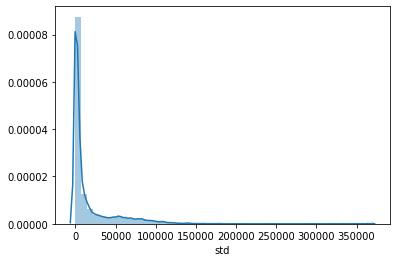

In [224]:
sns.distplot(summaries.droplevel(0,axis=1)['std'])

In [330]:
test = summaries.droplevel(0,axis=1)

In [236]:
test.head()

,mean,std,count
result,,,
'ENSG00000124614'_exon_0,2669.952035,1697.359728,198269
'ENSG00000124614'_exon_1,7265.607262,134.005824,17047
'ENSG00000124614'_exon_2,91.264996,1.440327,7302
'ENSG00000124614'_exon_3,168.318201,729.538785,2423
'ENSG00000124614'_other_0,335.297186,387.274152,21643


(1, 100)

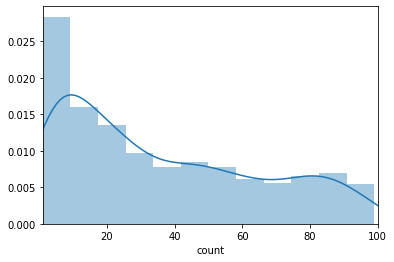

In [240]:
sns.distplot(test[(test['count'] < 100)]['count'])
plt.xlim(1,100)

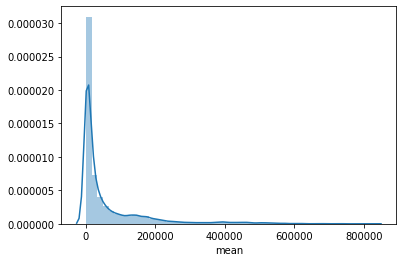

In [331]:
sns.distplot(test['mean'])


In [135]:
os.chdir('/Users/beth/Desktop')

In [136]:
! touch test_new.h5

In [137]:
def new_h5(counts,summaries,dset_file,new_dset_file):
    'takes counts and summaries output of seperate_into_peaks function'
    #load the dset_file
    dset = h5py.File(dset_file, 'r')
    dset = dset['matrix']
    indices = dset['indices']
    data = dset['data']
    features = dset['features']
    ids = features['id']
    
    #create the dset2 file and matrix group with barcodes and features group
    dset2 = h5py.File(new_dset_file, 'w')
    dset2.create_group('matrix')
    dset2['matrix'].create_dataset('barcodes', data = np.array(dset['barcodes']))
    dset2['matrix'].create_group('features')
    
    #add the new features to the old features ids
    summaries = summaries.reset_index()
    summaries['result'] = summaries['result'].str.replace("'","")
    old_genes = np.array(dset['features']['id'],dtype="|S30")
    new_genes = np.array(summaries['result'],dtype='|S30')
    dset2['matrix']['features'].create_dataset('id', data = np.append(old_genes,new_genes), dtype='|S30')
    
    #add the new features to the old features names
    old_genes_names = np.array(dset['features']['name'])
    dset2['matrix']['features'].create_dataset('name', data = np.append(old_genes_names, new_genes), dtype="|S30")
    
    #add extended genome array
    genome = dset['features']['genome'][0]
    genome = np.repeat(genome,dset2['matrix']['features']['id'].shape[0])
    dset2['matrix']['features'].create_dataset('genome', data = genome, dtype = "|S6")
    
    #add extended feature type array 
    feature_type = dset['features']['feature_type'][0]
    feature_type = np.repeat(feature_type,dset2['matrix']['features']['id'].shape[0])
    dset2['matrix']['features'].create_dataset('feature_type', data=feature_type, dtype = "|S15")
    
    #add tag
    tag = dset['features']['_all_tag_keys'][0]
    tag = np.array(tag,dtype='|S6')
    dset2['matrix']['features'].create_dataset('_all_tag_keys', data = tag, dtype = "|S6")
    
    #get a list of all features
    gene_list = list(pd.Series(dset2['matrix']['features']['id']).astype('str').str.replace('b','').str.replace("'",''))
    
    #get a list of all barcodes
    barcodes = list(pd.Series(dset['barcodes']).astype('str').str.replace('b','').str.replace("'",''))
    
    #update the indptr, data and indices arrays from the original dset by inserting new data
    indptr = np.array(dset['indptr'])
    data = np.array(dset['data'])
    indices = np.array(dset['indices'])
    counts = counts.reset_index()
    counts['result'] = counts['result'].str.replace("'",'')
    
    for i,b in enumerate(sorted(list(counts['barcode'].unique()))):
        if i % 1000 == 0:
            print(i)
        if b in barcodes:
            cell_counts = counts[counts['barcode']==b]
            cell_counts['gene_indice']=cell_counts['result'].map(lambda x: gene_list.index(x))
            cell_counts = cell_counts.sort_values(by='gene_indice')
            i = barcodes.index(b)
            pos = indptr[i]
            data = np.insert(data,pos,cell_counts['count'])              
            indices = np.insert(indices,pos,cell_counts['gene_indice'])
            indptr = np.append(indptr[:i+1],indptr[i+1:]+len(cell_counts))
        else: 
            continue
    
    #put the updated arrays in the new dset
    dset2['matrix'].create_dataset('indptr', data = indptr)
    dset2['matrix'].create_dataset('data', data = data)
    dset2['matrix'].create_dataset('indices', data = indices)
    
    #put the new matrix shape in the new dset
    new_shape =np.array([len(dset2['matrix']['features']['id']), len(dset2['matrix']['barcodes'])], dtype='int32')
    dset2['matrix'].create_dataset('shape', data = new_shape, dtype='int32')
    
    return dset2

In [6]:
os.chdir('/Users/beth/Desktop')

In [138]:
dset2 = new_h5(counts,summaries,'Parent_NGSC3_DI_PBMC_filtered_feature_bc_matrix.h5','test_new.h5')

0


/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:61: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


1000
2000
3000
4000
5000
6000
7000
8000
9000
10000
11000
12000
13000
14000
15000
16000
17000
18000
19000
20000
21000
22000
23000
24000
25000
26000
27000
28000
29000
30000
31000
32000
33000
34000
35000
36000
37000
38000
39000
40000
41000
42000
43000
44000
45000
46000
47000
48000
49000
50000
51000
52000
53000
54000
55000
56000
57000
58000
59000
60000
61000
62000
63000
64000
65000
66000
67000
68000
69000
70000
71000
72000
73000
74000
75000
76000
77000
78000
79000
80000
81000
82000
83000
84000
85000
86000
87000
88000
89000
90000
91000
92000
93000
94000
95000
96000
97000
98000
99000
100000
101000
102000
103000
104000
105000
106000
107000
108000
109000
110000
111000
112000
113000
114000
115000
116000
117000
118000
119000
120000
121000
122000
123000
124000
125000
126000
127000
128000
129000
130000
131000
132000
133000
134000
135000
136000
137000
138000
139000
140000
141000
142000
143000
144000
145000
146000
147000
148000
149000
150000
151000
152000
153000
154000
155000
156000
157000
158000
15

In [140]:
dset2['matrix'].keys()

<KeysViewHDF5 ['barcodes', 'data', 'features', 'indices', 'indptr', 'shape']>

In [238]:
def peak_correlations(base_gene_id, counts):
    counts = counts.reset_index()
    counts = counts.loc[counts['result'].str.contains(base_gene_id),].pivot(index = 'barcode', columns = "result")
    return counts.corr()

In [239]:
peak_correlations('ENSG00000204257', counts)

count  \
result                          'ENSG00000204257'_exon_0   
      result                                               
count 'ENSG00000204257'_exon_0                  1.000000   
      'ENSG00000204257'_exon_1                       NaN   
      'ENSG00000204257'_exon_2                  0.414537   
      'ENSG00000204257'_exon_3                  0.170148   
      'ENSG00000204257'_other_0                 0.155229   
      'ENSG00000204257'_other_1                      NaN   
      'ENSG00000204257'_other_2                 0.165643   

                                                          \
result                          'ENSG00000204257'_exon_1   
      result                                               
count 'ENSG00000204257'_exon_0                       NaN   
      'ENSG00000204257'_exon_1                  1.000000   
      'ENSG00000204257'_exon_2                  0.007778   
      'ENSG00000204257'_exon_3                       NaN   
      'ENSG00000204257'_other_0                      NaN   
      'ENSG00000204257'_other_1                      NaN   
      'ENSG00000204257'_other_2                      NaN   

                                                          \
result                          'ENSG00000204257'_exon_2   
      result                                               
count 'ENSG00000204257'_exon_0                  0.414537   
      'ENSG00000204257'_exon_1                  0.007778   
      'ENSG00000204257'_exon_2                  1.000000   
      'ENSG00000204257'_exon_3                  0.212875   
      'ENSG00000204257'_other_0                 0.227897   
      'ENSG00000204257'_other_1                      NaN   
      'ENSG00000204257'_other_2                 0.137252   

                                                          \
result                          'ENSG00000204257'_exon_3   
      result                                               
count 'ENSG00000204257'_exon_0                  0.170148   
      'ENSG00000204257'_exon_1                       NaN   
      'ENSG00000204257'_exon_2                  0.212875   
      'ENSG00000204257'_exon_3                  1.000000   
      'ENSG00000204257'_other_0                 0.037449   
      'ENSG00000204257'_other_1                      NaN   
      'ENSG00000204257'_other_2                -0.218218   

                                                           \
result                          'ENSG00000204257'_other_0   
      result                                                
count 'ENSG00000204257'_exon_0                   0.155229   
      'ENSG00000204257'_exon_1                        NaN   
      'ENSG00000204257'_exon_2                   0.227897   
      'ENSG00000204257'_exon_3                   0.037449   
      'ENSG00000204257'_other_0                  1.000000   
      'ENSG00000204257'_other_1                       NaN   
      'ENSG00000204257'_other_2                 -0.161359   

                                                           \
result                          'ENSG00000204257'_other_1   
      result                                                
count 'ENSG00000204257'_exon_0                        NaN   
      'ENSG00000204257'_exon_1                        NaN   
      'ENSG00000204257'_exon_2                        NaN   
      'ENSG00000204257'_exon_3                        NaN   
      'ENSG00000204257'_other_0                       NaN   
      'ENSG00000204257'_other_1                       NaN   
      'ENSG00000204257'_other_2                       NaN   

                                                           
result                          'ENSG00000204257'_other_2  
      result                                               
count 'ENSG00000204257'_exon_0                   0.165643  
      'ENSG00000204257'_exon_1                        NaN  
      'ENSG00000204257'_exon_2                   0.137252  
      'ENSG00000204257'_exon_3                  -0.218218  
     

In [200]:
df.iloc[9,]

index                                                         9
gene_id                                       'ENSG00000147604'
chrom                                                      chr8
exons         [3557, 3558, 3559, 3560, 3561, 3562, 3563, 356...
barcodes      [CATTTCATCCTACCAC-1, ACGGTCGTCTCTAAGG-1, TCCGA...
read_stops    [54262, 143183, 30356, 861, 986, 8717, 87907, ...
Name: 9, dtype: object

In [201]:
test = df[df['gene_id']=="'ENSG00000124614'"]

In [202]:
test.head()

,index,gene_id,chrom,exons,barcodes,read_stops
0,0,'ENSG00000124614',chr6,"[0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13,...","[GGGAGTACAGAGTGTG-1, TGTGATGCAGTTTCAG-1, GTAAT...","[7292, 334840, 53004, 165139, 357994, 211003, ..."


In [209]:
df.head()

,index,gene_id,chrom,exons,barcodes,read_stops
0,0,'ENSG00000124614',chr6,"[0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13,...","[GGGAGTACAGAGTGTG-1, TGTGATGCAGTTTCAG-1, GTAAT...","[7292, 334840, 53004, 165139, 357994, 211003, ..."
1,1,'ENSG00000204628',chr5,"[3307, 3308, 3309, 3310, 3311, 3312, 3313, 331...","[ATTCCCGTCCAAACCA-1, AGAAGCGCAACGGGTA-1, TCACG...","[68499, 776, 109, 1261, 111, 785, 785, 785, 89..."
2,2,'ENSG00000114391',chr3,"[0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13,...","[CAATCGAGTTGCGGCT-1, ATTCACTTCAGGCGAA-1, TACGG...","[77, 178240, 250634, 180083, 134565, 24195, 21..."
3,3,'ENSG00000026025',chr10,"[7709, 7710, 7711, 7712, 7713, 7714, 7715, 771...","[GTAGGTTAGGGATCAC-1, CATGGATTCTCCCATG-1, CTGCC...","[63689, 6151, 5780, 220549, 6060, 299866, 6028..."
4,4,'ENSG00000184009',chr17,"[429, 430, 431, 432, 433, 434, 435, 436, 437, ...","[GTGTTAGCATATCGGT-1, TATATCCGTTGTACGT-1, ACAAC...","[127861, 56287, 75, 75, 75, 75, 75, 71, 205, 1..."


In [225]:
def graph_exons(gene_base_id,df2):
        df=df2.copy()
        df=df[df['gene_id']=="'"+gene_base_id+"'"]
        df=df.reset_index()
        
        if df.loc[0,'strand'] == "+":
            start = min(df.loc[0,'exons'])
            exons = list(map(lambda x: x - start, df.loc[0,'exons']))
            read_stops = list(map(lambda x: int(x) - start, df.loc[0,'read_stops']))
        if df.loc[0,'strand'] == "-":
            start = max(df.loc[0,'exons'])
            exons = list(map(lambda x: -1*(x - start), df.loc[0,'exons']))
            read_stops = list(map(lambda x: -1*(int(x) - start), df.loc[0,'read_stops']))
        
        read_stops_dict = defaultdict(int)
        
        for stop in read_stops:
            read_stops_dict[stop] += 1
            
        read_stops_exons=defaultdict(int)
        for key in exons:
            if read_stops_dict.get(key):
                read_stops_exons[key] = read_stops_dict.get(key)
                
        for_bgm = [x for y in [[exons.index(i)]*n for i, n in read_stops_exons.items()] for x in y]
        for_bgm = np.array(for_bgm).reshape([-1,1])
        result = BayesianGaussianMixture(4,max_iter=2000).fit(for_bgm).predict(for_bgm)
        
        exons_results = pd.DataFrame({'result':result,'pos':for_bgm.flatten()})
        exons_results['pos'] = exons_results['pos'].map(lambda x: exons[x])
        
        group_0 = exons_results[exons_results['result'] == 0]
        group_1 = exons_results[exons_results['result'] == 1]
        group_2 = exons_results[exons_results['result'] == 2]
        group_3 = exons_results[exons_results['result'] == 3]
        
        sns.distplot(group_0['pos'])
        sns.distplot(group_1['pos'])
        sns.distplot(group_2['pos'])
        sns.distplot(group_3['pos'])

In [222]:
df2.head()

,index,gene_id,name,chrom,exons,strand,barcodes,read_stops
0,500,'ENSG00000204257','HLA-DMA',chr6,"[32948613, 32948614, 32948615, 32948616, 32948...",-,"[TTACAGGGTACTCCCT-1, TAGCACACACCTCAGG-1, CTCAA...","[32948619, 32948805, 32955989, 32948644, 32948..."
1,501,'ENSG00000196924','FLNA',chrX,"[154370873, 154370874, 154370875, 154370876, 1...",-,"[TGTGCGGAGCTTGTGT-1, ACTGCAAGTGAGCAGT-1, GGTAG...","[154348532, 154348568, 154348536, 154348635, 1..."
2,502,'ENSG00000121552','CSTA',chr3,"[122341628, 122341629, 122341630, 122341631, 1...",+,"[GTGTGATTCGGAGTGA-1, GTCATGAAGAATCGCG-1, CTCAA...","[122341581, 122341470, 122341648, 122341544, 1..."
3,503,'ENSG00000062716','VMP1',chr17,"[59834012, 59834013, 59834014, 59834015, 59834...",+,"[GCTTGGGAGCTTACGT-1, TCAGTGACACTTTATC-1, CCGAT...","[59760029, 59788703, 59785629, 59747774, 59760..."
4,504,'ENSG00000135218','CD36',chr7,"[80623923, 80623924, 80623925, 80623926, 80623...",+,"[AGCCAATGTTGTAGCT-1, TCTACCGCAGGTCAGA-1, CCCTC...","[80679177, 80655741, 80679280, 80679154, 80655..."


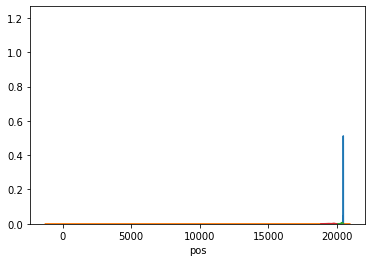

In [236]:
graph_exons('ENSG00000204257',df2)

In [237]:
max(df2.loc[0,'exons']) - min(df2.loc[0,'exons'])

20480

In [227]:
import seaborn as sns

In [213]:
import matplotlib.pyplot as plt

In [76]:
#fast!
for_bgm = [x for y in [[i]*n for i, n in read_stops_exons.items()] for x in y]

In [77]:
for_bgm = np.array(for_bgm).reshape([-1,1])

In [78]:
result = BayesianGaussianMixture(4,max_iter=300).fit(for_bgm).predict(for_bgm)

In [79]:
for_bgm.flatten().shape

(3107752,)

In [84]:
test = pd.DataFrame({'result':result,'pos':for_bgm.flatten(),'barcode':barcodes_test})

In [87]:
pd.Series(result).value_counts()

0    2166283
1     727600
3     110472
2     103397
dtype: int64

In [81]:
barcodes_test = [np.array(i).flatten() for i in barcodes_exons.values()]

In [82]:
barcodes_test = np.concatenate(barcodes_test)

In [83]:
barcodes_test.shape

(3107752,)

In [ ]:
temp = temp.groupby(['barcode','call']).count().reset_index()

In [177]:
test_2 = test[test['result'] == 2]

In [178]:
test_1 = test[test['result'] == 1]

In [179]:
test_0 = test[test['result'] == 0]

In [180]:
test_3 = test[test['result'] == 3]

In [96]:
import matplotlib.pyplot as plt

In [97]:
import seaborn as sns

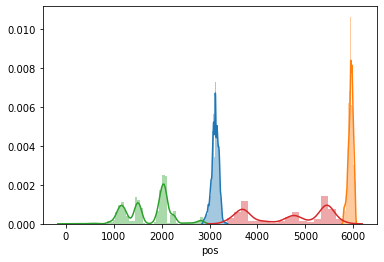

In [181]:
sns.distplot(test_0['pos'])
sns.distplot(test_1['pos'])
sns.distplot(test_2['pos'])
sns.distplot(test_3['pos'])

In [100]:
#fast!
for_bgm = [x for y in [[i]*n for i, n in read_stops_introns.items()] for x in y]

In [101]:
for_bgm = np.array(for_bgm).reshape([-1,1])

In [102]:
for_bgm.shape

(0, 1)

In [98]:
result = BayesianGaussianMixture(4,max_iter=300).fit(for_bgm).predict(for_bgm)

ValueError: Found array with 0 sample(s) (shape=(0, 1)) while a minimum of 2 is required.

In [79]:
for_bgm.flatten().shape

(3107752,)

In [84]:
test = pd.DataFrame({'result':result,'pos':for_bgm.flatten(),'barcode':barcodes_test})

In [85]:
min = test[test['result']==0]['pos'].min()

In [86]:
max = test[test['result']==0]['pos'].max()

In [87]:
pd.Series(result).value_counts()

0    2166283
1     727600
3     110472
2     103397
dtype: int64

In [81]:
barcodes_test = [np.array(i).flatten() for i in barcodes_exons.values()]

In [82]:
barcodes_test = np.concatenate(barcodes_test)

In [83]:
barcodes_test.shape

(3107752,)

In [ ]:
temp = temp.groupby(['barcode','call']).count().reset_index()

In [187]:
test_2 = test2[test2['result'] == 2]

In [188]:
test_1 = test2[test2['result'] == 1]

In [189]:
test_0 = test2[test2['result'] == 0]

In [190]:
test_3 = test2[test2['result'] == 3]

In [92]:
import matplotlib.pyplot as plt

In [93]:
import seaborn as sns

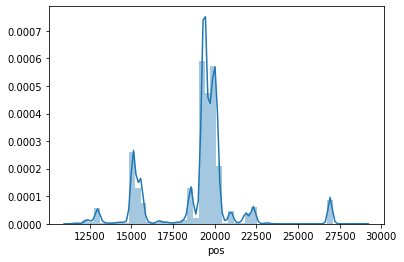

In [192]:
sns.distplot(test_0['pos'])


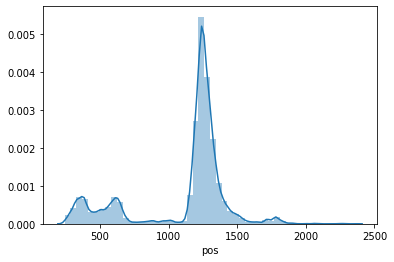

In [193]:
sns.distplot(test_1['pos'])

RuntimeError: Selected KDE bandwidth is 0. Cannot estiamte density.

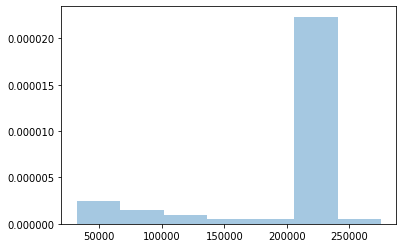

In [194]:
sns.distplot(test_2['pos'])

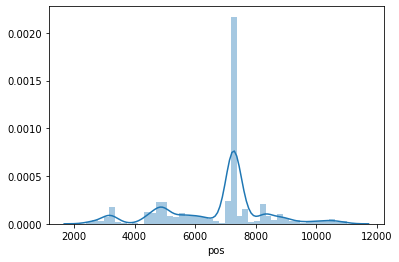

In [195]:
sns.distplot(test_3['pos'])